EJECUTAR CELDA A CELDA LEYENDO LOS COMENTARIOS, NO ES NECESARIO USAR GPU PORQUE SE CARGAN LOS DATOS YA EJECUTADOS. SI SE VUELVE A EJECUTAR LA EXPLORACIÓN SE RECOMIENDA EJECUTAR CON GPU.

Este notebook contiene un entrenamiento de cada configuración elegida finalmente en el notebook Models_small_hypertuning. Para el entrenamiento se utilizan todos los datos (con los 4400 momentos temporales).


If on google collab, if not skip the following cell

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
#CHANGE ACCORDING TO DIRECTORY
%cd '/content/gdrive/MyDrive/TFG_Matematicas'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/TFG_Matematicas


## Preparation to train models

In [3]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, Flatten, Dense, Dropout, Input, SimpleRNN, LSTM, Input, BatchNormalization, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
#import visualkeras
from keras.utils import plot_model
from utils.utils import *


In [4]:
# UNCOMMENT BELOW IF USING TPU
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# print("All devices: ", tf.config.list_logical_devices('TPU'))
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [5]:
# UNCOMMENT BELOW IF USING GPU
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [6]:
# Load data indexes
train_idxs = read_indexes('./utils/train.txt')
validation_idxs =  read_indexes('./utils/validation.txt')
test_idxs = read_indexes('./utils/test.txt')

In [7]:
# Load parameters for each set
data_indexes = [(i+1,j+1) for i in range(10) for j in range(2000)]
parameters = load_parameter_list()
df_parameters = pd.DataFrame(parameters, columns=['cx', 'cy', 'a', 'b', 'theta', 'e1', 'e2'])
df_parameters['data_index'] = data_indexes

y_train = df_parameters[df_parameters['data_index'].isin(train_idxs)].drop('data_index', axis = 1)
y_validation = df_parameters[df_parameters['data_index'].isin(validation_idxs)].drop('data_index', axis = 1)
y_test = df_parameters[df_parameters['data_index'].isin(test_idxs)].drop('data_index', axis = 1)

In [8]:
# Load data (only train and validation needed). Load ALL DATA.
X_train = np.array(load_data_multithreaded(train_idxs,50))
print('train loaded')
X_validation = np.array(load_data_multithreaded(validation_idxs,50))
print('validation loaded')
#X_test = np.array(load_data_multithreaded(test_idxs,50,))
#print('test loaded')

train loaded
validation loaded


# Preparing metrics

Prepare custom metrics to monitor parameter e1 and parameter e2

In [9]:
def e1_mse(y_true, y_pred):
    output = y_pred[:, -2]
    output_mae = tf.keras.metrics.mean_squared_error(y_true[:, -2], output)
    return output_mae
def e2_mse(y_true, y_pred):
    output = y_pred[:, -1]
    output_mae = tf.keras.metrics.mean_squared_error(y_true[:, -1], output)
    return output_mae

def e1_mae(y_true, y_pred):
    output = y_pred[:, -2]
    output_mae = tf.keras.metrics.mean_absolute_error(y_true[:, -2], output)
    return output_mae
def e2_mae(y_true, y_pred):
    output = y_pred[:, -1]
    output_mae = tf.keras.metrics.mean_absolute_error(y_true[:, -1], output)
    return output_mae

def e1_rmse(y_true, y_pred):
    output = y_pred[:, -2]
    output_rmse = rmse(y_true[:, -2], output)
    return output_rmse
def e2_rmse(y_true, y_pred):
    output = y_pred[:, -1]
    output_rmse = rmse(y_true[:, -1], output)
    return output_rmse

In [10]:
METRICS=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),
         tf.keras.metrics.MeanAbsoluteError(name='mae'),
         e1_mse,e2_mse,e1_mae,e2_mae]

# Import libraries to log models and training

In [33]:
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import os
dir_weights = "models/weights" # Directory to store models
dir_training_history = "models/training" # Directory to store models training

The following cells are divided by architecture type. In each section, a code is prepared to tain each model and save the weights. The training is already executed so executing the following cells will load the models and only show training plots.

# Feedforward model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 74800)             0         
                                                                 
 dense_18 (Dense)            (None, 1024)              76596224  
                                                                 
 dense_19 (Dense)            (None, 512)               524800    
                                                                 
 dense_20 (Dense)            (None, 256)               131328    
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 7)                

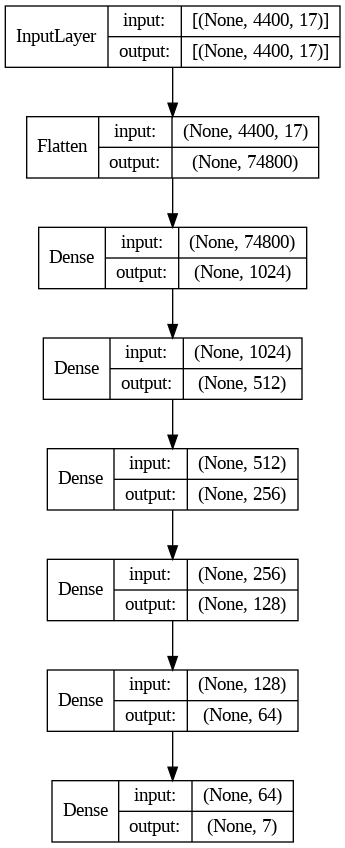

In [34]:
model_name = "feedforward"
feedforward = tf.keras.Sequential([
    Input(shape=(4400, 17)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7)
])

feedforward.compile(optimizer='adam', loss='mse', metrics=[METRICS])
feedforward.summary()
plot_model(feedforward, to_file=f'figures/{model_name}_1.png', show_shapes=True, show_layer_names=False)
#visualkeras.layered_view(feedforward, legend=True, to_file='figures/feedforward_2.png', spacing = 15)

In [35]:
model_path = dir_weights + f'/best_model_{model_name}.h5'
training_path = dir_training_history + f'/training_history_{model_name}.csv'

if os.path.isfile(training_path):
  # Load the existing model
  feedforward.load_weights(model_path)
  print(f"Loaded existing {model_name} model from weights file.")

else:
  os.makedirs(os.path.dirname(training_path), exist_ok=True)

  # Train a new model if the file doesn't exist
  print(f"Model not found. Training a new {model_name} model...")

  # Callbacks
  #early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, restore_best_weights=True)
  csv_logger = CSVLogger(training_path)
  checkpoint = ModelCheckpoint(model_path, save_best_only=True, save_weights_only = True, verbose = 1)
  checkpoint_last = ModelCheckpoint(model_path, save_best_only=True, save_weights_only = True, verbose = 1)
  # Train the model
  feedforward.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100, verbose = 1, callbacks=[csv_logger,checkpoint])

Loaded existing feedforward model from weights file.


models/training/training_history_feedforward.csv


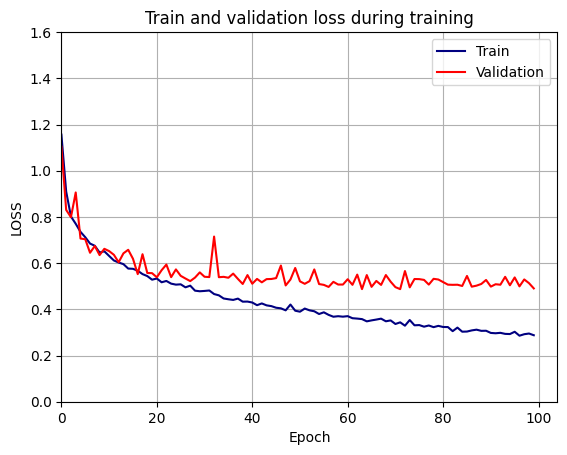

In [36]:
history_df = pd.read_csv(training_path)
plot_metrics(history_df, 'loss', file = f'figures/{model_name}_loss')

In [37]:
# Best training epoch
history_df.sort_values('loss').iloc[0][['epoch','loss']]

epoch    96.000000
loss      0.285834
Name: 96, dtype: float64

In [38]:
# Best validation epoch
history_df.sort_values('val_loss').iloc[0][['epoch','val_loss']]

epoch       71.000000
val_loss     0.487356
Name: 71, dtype: float64

# Convolutional model

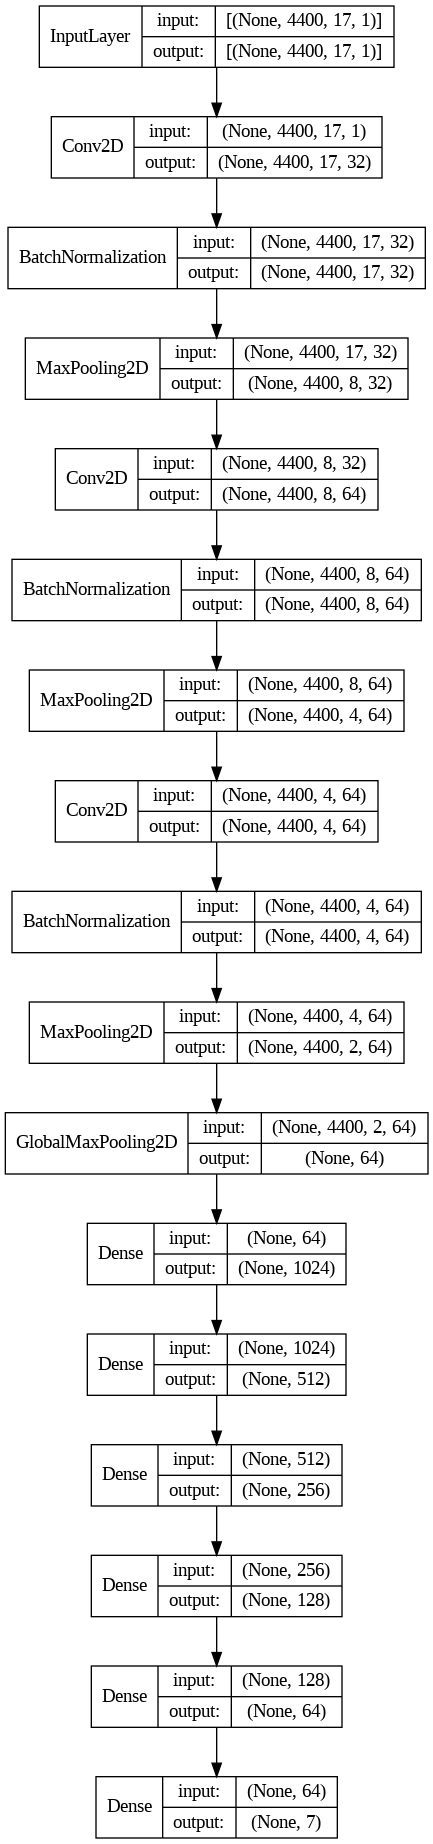

In [39]:
model_name = "cnn"
cnn = tf.keras.Sequential([
  Conv2D(32, (3, 3), activation='relu', input_shape=(4400, 17, 1), padding='same'),
  BatchNormalization(),
  MaxPooling2D((1, 2)),

  Conv2D(64, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D((1, 2)),

  Conv2D(64, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D((1, 2)),

  GlobalMaxPooling2D(),

  Dense(1024, activation='relu'),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(7)
])

cnn.compile(optimizer='adam', loss='mse', metrics=[METRICS])
#cnn.summary()
plot_model(cnn, to_file=f'figures/{model_name}_1.png', show_shapes=True, show_layer_names=False)
#visualkeras.layered_view(cnn, legend=True, to_file='figures/cnn_2.png', spacing = 15)

In [40]:
model_path = dir_weights + f'/best_model_{model_name}.h5'
training_path = dir_training_history + f'/training_history_{model_name}.csv'

if os.path.isfile(training_path):
  # Load the existing model
  cnn.load_weights(model_path)
  print(f"Loaded existing {model_name} model from weights file.")

else:
  os.makedirs(os.path.dirname(training_path), exist_ok=True)

  # Train a new model if the file doesn't exist
  print(f"Model not found. Training a new {model_name} model...")

  # Callbacks
  #early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, restore_best_weights=True)
  csv_logger = CSVLogger(training_path)
  checkpoint = ModelCheckpoint(model_path, save_best_only=True, save_weights_only = True, verbose = 1)

  # Train the model
  cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100, verbose = 1, callbacks=[csv_logger,checkpoint])

Loaded existing cnn model from weights file.


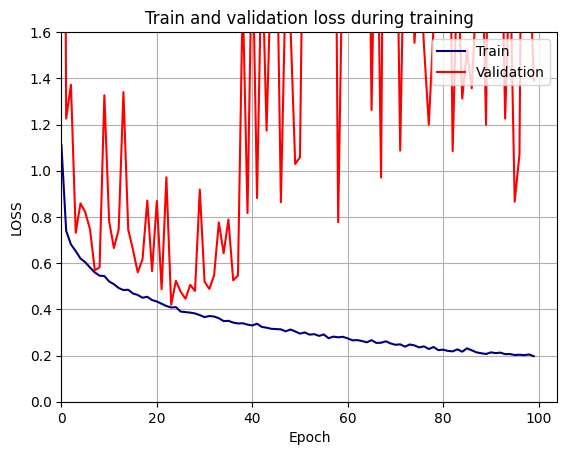

In [41]:
history_df = pd.read_csv(training_path)
plot_metrics(history_df, 'loss', file = f'figures/{model_name}_loss')

In [42]:
# Best training epoch
history_df.sort_values('loss').iloc[0][['epoch','loss']]

epoch    99.000000
loss      0.196854
Name: 99, dtype: float64

In [44]:
# Best validation epoch
history_df.sort_values('val_loss').iloc[0][['epoch','val_loss']]

epoch       23.000000
val_loss     0.419872
Name: 23, dtype: float64

#  Recurrent Neural Network Model with LSTM

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4400, 25)          4300      
                                                                 
 flatten_3 (Flatten)         (None, 110000)            0         
                                                                 
 dense_30 (Dense)            (None, 1024)              112641024 
                                                                 
 dense_31 (Dense)            (None, 512)               524800    
                                                                 
 dense_32 (Dense)            (None, 256)               131328    
                                                                 
 dense_33 (Dense)            (None, 128)               32896     
                                                                 
 dense_34 (Dense)            (None, 64)               

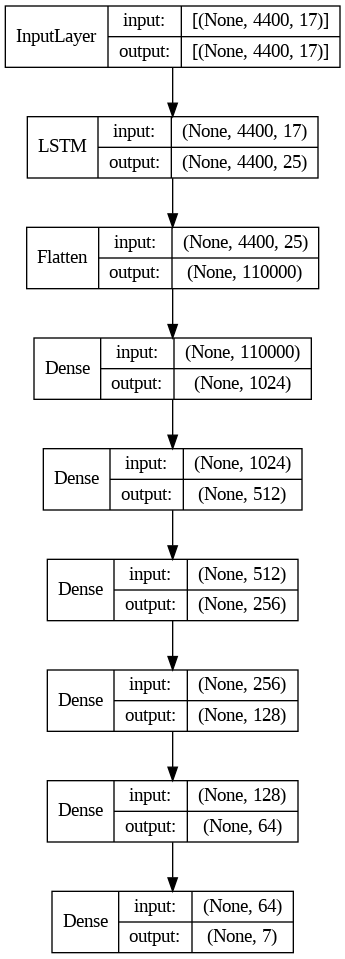

In [45]:
model_name = "rnn_lstm"
rnn_lstm = tf.keras.Sequential([
    LSTM(25, input_shape=(4400, 17), return_sequences = True),
    Flatten(),
    Dense(1024, activation='leaky_relu'),
    Dense(512, activation='leaky_relu'),
    Dense(256, activation='leaky_relu'),
    Dense(128, activation='leaky_relu'),
    Dense(64, activation='leaky_relu'),
    Dense(7)
])

rnn_lstm.compile(optimizer='adam', loss='mse', metrics=METRICS)
rnn_lstm.summary()
plot_model(rnn_lstm, to_file=f'figures/{model_name}_1.png', show_shapes=True, show_layer_names=False)
#visualkeras.layered_view(rnn, legend=True, to_file='figures/rnnlstm_2.png', spacing = 15)

In [46]:
model_path = dir_weights + f'/best_model_{model_name}.h5'
training_path = dir_training_history + f'/training_history_{model_name}.csv'

if os.path.isfile(training_path):
  # Load the existing model
  rnn_lstm.load_weights(model_path)
  print(f"Loaded existing {model_name} model from weights file.")

else:
  os.makedirs(os.path.dirname(training_path), exist_ok=True)

  # Train a new model if the file doesn't exist
  print(f"Model not found. Training a new {model_name} model...")

  # Callbacks
  #early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, restore_best_weights=True)
  csv_logger = CSVLogger(training_path)
  checkpoint = ModelCheckpoint(model_path, save_best_only=True, save_weights_only = True, verbose = 1)

  # Train the model
  rnn_lstm.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100, verbose = 1, callbacks=[csv_logger,checkpoint])

Loaded existing rnn_lstm model from weights file.


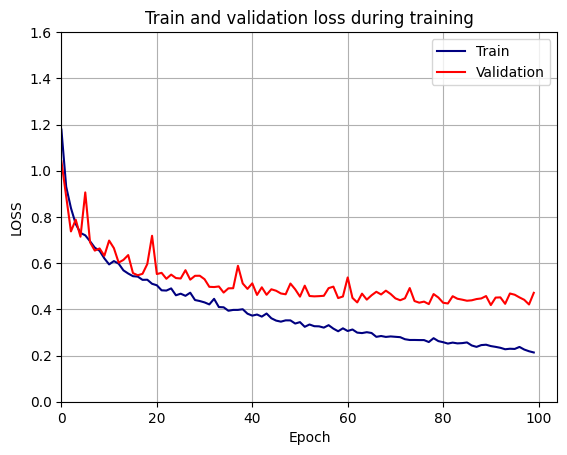

In [47]:
history_df = pd.read_csv(training_path)
plot_metrics(history_df, 'loss', file = f'figures/{model_name}_loss')

In [48]:
# Best training epoch
history_df.sort_values('loss').iloc[0][['epoch','loss']]

epoch    99.000000
loss      0.213216
Name: 99, dtype: float64

In [50]:
# Best training epoch
history_df.sort_values('val_loss').iloc[0][['epoch','val_loss']]

epoch       90.000000
val_loss     0.418404
Name: 90, dtype: float64